### Using the MIT-BIH Arrhythymia Dataset

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [13]:
data = pd.read_csv("MIT-BIH_Arrhythmia.csv")
data['type'] = data['type'].replace({'N': 1, 'A': 0})
data.head()

,record,type,0_pre-RR,0_post-RR,0_pPeak,0_tPeak,0_rPeak,0_sPeak,0_qPeak,0_qrs_interval,...,1_qPeak,1_qrs_interval,1_pq_interval,1_qt_interval,1_st_interval,1_qrs_morph0,1_qrs_morph1,1_qrs_morph2,1_qrs_morph3,1_qrs_morph4
0,101,1,76,313,0.074347,-0.160548,1.036401,-0.285662,-0.026824,41,...,0.025930,2,18,22,2,0.025930,0.025930,0.025930,0.025436,0.025436
1,101,1,313,315,-0.052079,-0.264784,0.886597,-0.366298,-0.059710,21,...,-0.042009,26,27,62,9,-0.042009,-0.029498,0.005012,0.030892,0.002986
2,101,1,315,321,-0.062151,-0.296983,0.991859,-0.410306,-0.065686,22,...,0.009528,3,8,12,1,0.009528,0.009528,0.008786,0.008786,0.008368
3,101,1,321,336,-0.063322,-0.281386,1.034903,-0.403880,-0.071750,22,...,-0.020536,6,9,16,1,-0.020536,-0.020257,-0.018965,-0.016968,-0.014555
4,101,1,336,344,-0.062915,1.046914,1.046408,1.046408,-0.074639,11,...,0.016053,16,5,31,10,0.016053,0.006742,0.002782,-0.007798,-0.051155


##### Pre-processing the data

In [16]:
if 'type' in data.columns:
    data['type'] = data['type'].astype(str)

encoder = LabelEncoder()
data['type'] = encoder.fit_transform(data['type'])

features = data.select_dtypes(include=[np.number]).drop(columns=['type'], errors='ignore')
scaler = MinMaxScaler()
data[features.columns] = scaler.fit_transform(features)

X = data.drop(columns=['type'])
y = data['type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Reshape cause of 1D CNN
X_train_reshaped = np.expand_dims(X_train.values, axis=2)
X_test_reshaped = np.expand_dims(X_test.values, axis=2)

##### 1-D CNN Model

In [17]:
def create_1d_cnn(input_shape):
    model = Sequential([
        # 1st Convolutional Layer
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        
        # 2nd Convolutional Layer
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        # 3rd Convolutional Layer
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        # Flatenning the layers
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [18]:
input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])  # Shape of input data
model = create_1d_cnn(input_shape)

# Summary of the model
model.summary()

c:\Users\vivah\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 31, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 31, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 13, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 4, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,153 (285.75 KB)

 Trainable params: 72,705 (284.00 KB)

 Non-trainable params: 448 (1.75 KB)

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Checkpoint to save the best model
model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

# Train the model
history = model.fit(
    X_train_reshaped, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)


Epoch 1/50
1943/1943 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8734 - loss: -187024.5000 - val_accuracy: 0.7992 - val_loss: -6170572.5000
Epoch 2/50
1943/1943 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8679 - loss: -13075626.0000 - val_accuracy: 0.9011 - val_loss: -72095752.0000
Epoch 3/50
1943/1943 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8769 - loss: -95779512.0000 - val_accuracy: 0.9177 - val_loss: -204440144.0000
Epoch 4/50
1943/1943 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8725 - loss: -332936928.0000 - val_accuracy: 0.9102 - val_loss: -707828416.0000
Epoch 5/50
1943/1943 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8769 - loss: -783356928.0000 - val_accuracy: 0.0492 - val_loss: 2744683264.0000
Epoch 6/50
1943/1943 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8747 - loss: -1593893888.0000 - val_accuracy: 0.8782 - val_loss: -3100912128.0000
Epoch 7/50
1943/1943 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.8772 - loss: -2797745664.0000 - val_accuracy: 

In [22]:
# Evaluating on test set
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

607/607 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9067 - loss: -5472442646528.0000
Test Accuracy: 90.57%


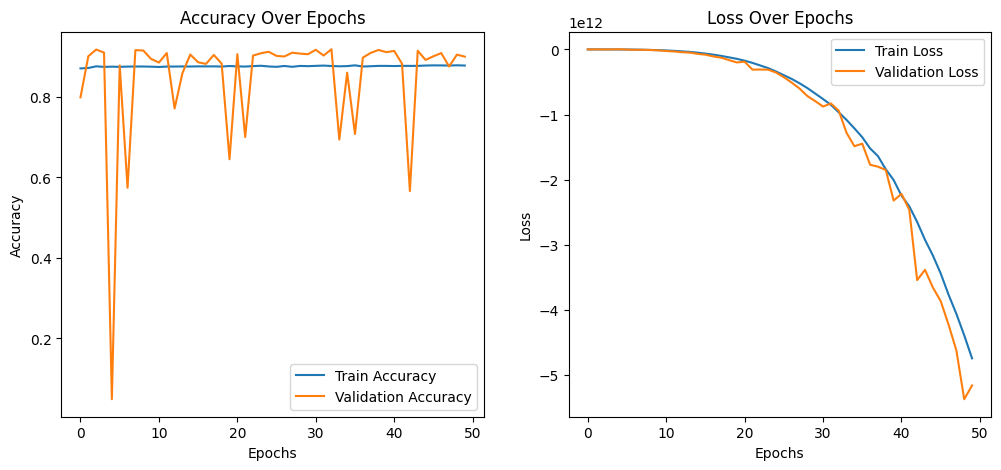

In [24]:
# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.show()

In [27]:
print("Unique classes in y_test:", set(y_test))

Unique classes in y_test: {0, 1, 2}


In [28]:
# Map labels to binary: 0 for normal, 1 for arrhythmic
y_test_binary = y_test.apply(lambda x: 1 if x == 1 else 0)

# Also adjust training labels if needed
y_train_binary = y_train.apply(lambda x: 1 if x == 1 else 0)

In [29]:
# Generate classification report
predictions_binary = (model.predict(X_test_reshaped) > 0.5).astype(int)
print(classification_report(y_test_binary, predictions_binary, target_names=['Normal', 'Arrhythmic']))

607/607 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
              precision    recall  f1-score   support

      Normal       1.00      0.91      0.95     19419
  Arrhythmic       0.00      0.67      0.00         3

    accuracy                           0.91     19422
   macro avg       0.50      0.79      0.48     19422
weighted avg       1.00      0.91      0.95     19422

